In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("AZURE_OPENAI_API_KEY")
_set_env("AZURE_OPENAI_ENDPOINT")

Let's instantiate the LLM and generate outputs.

There are many ways we can provide the input to these chat models.

In [2]:
from langchain_openai import ChatOpenAI, AzureChatOpenAI

llm = AzureChatOpenAI(
    model="gpt-4o", # replace with your model name from Azure Openai deployments
    api_version="2024-10-21",
    temperature=0
)
# provide a string as input
llm.invoke("Hi!")

AIMessage(content='Hello! 😊 How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 9, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BKTmiGIOVSkzEyKBzeIat2DLupxxC', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_co

There is another way to invoke LLM.

In [3]:
from langchain_core.messages import HumanMessage

# list of messages (Langchain way)
## let's create the messages with `name`s (labels) inside a list
msg = HumanMessage(content="Hello GPT!", name="MS")
messages = [msg]

# invoke with a list of messages 
llm.invoke(messages)

AIMessage(content='Hello! 😊 How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BKTmi1Ty5XdhnUKbdBy80IVbV0e5H', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_c

In [4]:
# we can also stream the output the chatgpt way
for chunk in llm.stream(messages):
    print(chunk.content, end="|", flush=True)

||Hello|!| 😊| How| can| I| assist| you| today|?||

### Create the graphs

First of all, let's write an utility to draw the graphs built

In [8]:
from IPython.display import Image, display, Markdown
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
def draw_graph(compiled_graph):
    try:
        return Image(compiled_graph.get_graph(xray=1).draw_mermaid_png())
    except:
        return None

In [9]:
from langgraph.graph import START, StateGraph

def my_node(state, config):
    # this node increments "x" by 1
   return {"x": state["x"] + 1}

# we can build state graph of type dict/typed dict/pydantic model/dataclass
# let's start with dict and build a simple graph of 1 node
builder = StateGraph(dict)
builder.add_node(my_node)  # node name will be 'my_node'
builder.add_edge(START, "my_node")
graph = builder.compile()

# draw the graph
# display(draw_graph(graph))

# pass the input to the graph
graph.invoke({"x": 1})


{'x': 2}

In [10]:
from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph

def reducer(a: list, b: int | None) -> list:
    if b is not None:
        return a + [b]
    return a

class State(TypedDict):
    x: Annotated[list, reducer]

class ConfigSchema(TypedDict):
    r: float

graph = StateGraph(State, config_schema=ConfigSchema)

def node(state: State, config: RunnableConfig) -> dict:
    r = config["configurable"].get("r", 1.0)
    x = state["x"][-1]
    next_value = x * r * (1 - x)
    return {"x": next_value}
    
graph.add_node("A", node)

# Equivalent to calling add_edge(START, "A")
graph.set_entry_point("A")

# Equivalent to calling add_edge("A", END)
graph.set_finish_point("A")
compiled = graph.compile()

# display(Image(compiled.get_graph(xray=1).draw_png()))
print(compiled.config_specs)

step1 = compiled.invoke({"x": 0.5}, {"configurable": {"r": 3.0}})
print(step1)


[ConfigurableFieldSpec(id='r', annotation=<class 'float'>, name=None, description=None, default=None, is_shared=False, dependencies=None)]
{'x': [0.5, 0.75]}


In [11]:
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

# State in LangGraph can be a TypedDict, Pydantic model, or dataclass. 
class State(TypedDict):
    messages: list[AnyMessage] # define the type of the keys
    extra_field: int

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")
    # appends the new AI message to the existing messages
    return {"messages": messages + [new_message], "extra_field": 10}

# build and compile the graph
graph_builder = StateGraph(State)
graph_builder.add_node(node)
graph_builder.set_entry_point("node")
graph = graph_builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
from langchain_core.messages import HumanMessage
# send the input human message
result = graph.invoke({"messages": [HumanMessage("Hi")]})
# the result should append the AImessage("Hello!") along with the extra field
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

### Reducers

In [13]:
from typing_extensions import Annotated
from langgraph.graph import START


def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    return left + right

# For TypedDict state schemas, we can define reducers by annotating the corresponding field of the state with a reducer function.
class State(TypedDict):
    # Each key in the state can have its own independent reducer function, 
    # which controls how updates from nodes are applied. 
    # If no reducer function is explicitly specified 
    # then it is assumed that all updates to the key should override it.
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}

# build and compile the graph with this single node
graph = StateGraph(State).add_node(node).add_edge(START, "node").compile()

# input HumanMessage
result = graph.invoke({"messages": [HumanMessage("Hi")]})

# print each of the messages
# we expect the input HumanMessage new AImessage
for message in result["messages"]:
    message.pretty_print()


================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


Can also use OpenAI style messages

In [14]:
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    extra_field: int

# the same can be represented by MessagesState
class State(MessagesState):
    extra_field: int


def node(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": [new_message], "extra_field": 10}


graph = StateGraph(State).add_node(node).set_entry_point("node").compile()
# can also invoke using openai style messages
input_message = {"role": "user", "content": "Hi"}

result = graph.invoke({"messages": [input_message]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


Add multiple nodes

Build graph using `.add_sequence`

The following cells are equivalent
```
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")
```
and 
```
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# Add edges
graph_builder.add_edge(START, "step_1")
graph_builder.add_edge("step_1", "step_2")
graph_builder.add_edge("step_2", "step_3")
```

### Debugging

In [17]:
import operator
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

class State(TypedDict):
    alist: Annotated[list, operator.add]
    another_list: Annotated[list, operator.add]

builder = StateGraph(State)
builder.add_node("a", lambda _state: {"another_list": ["hi"]})
builder.add_node("b", lambda _state: {"alist": ["there"]})
builder.add_edge("a", "b")
builder.add_edge(START, "a")
graph = builder.compile()

# display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
# with stream mode values, prints all the values
for event in graph.stream({"alist": ['Ex for stream_mode="values"']}, stream_mode="values"):
    print(event)

{'alist': ['Ex for stream_mode="values"'], 'another_list': []}
{'alist': ['Ex for stream_mode="values"'], 'another_list': ['hi']}
{'alist': ['Ex for stream_mode="values"', 'there'], 'another_list': ['hi']}


In [19]:
# with stream mode updates, only the updates to the keys are printed
for event in graph.stream({"alist": ['Ex for stream_mode="updates"']}, stream_mode="updates"):
    print(event)

{'a': {'another_list': ['hi']}}
{'b': {'alist': ['there']}}


In [20]:
# debug -> task (state input) and task_result (output) and triggers
for event in graph.stream({"alist": ['Ex for stream_mode="debug"']}, stream_mode="debug"):
    print(event)


{'type': 'task', 'timestamp': '2025-04-09T18:14:05.214900+00:00', 'step': 1, 'payload': {'id': '0d910bb5-3ac7-cedf-941e-b32d858eb542', 'name': 'a', 'input': {'alist': ['Ex for stream_mode="debug"'], 'another_list': []}, 'triggers': ('branch:to:a',)}}
{'type': 'task_result', 'timestamp': '2025-04-09T18:14:05.222263+00:00', 'step': 1, 'payload': {'id': '0d910bb5-3ac7-cedf-941e-b32d858eb542', 'name': 'a', 'error': None, 'result': [('another_list', ['hi'])], 'interrupts': []}}
{'type': 'task', 'timestamp': '2025-04-09T18:14:05.222263+00:00', 'step': 2, 'payload': {'id': 'ffea2e27-948f-a7fb-bdd5-a75eba0945f1', 'name': 'b', 'input': {'alist': ['Ex for stream_mode="debug"'], 'another_list': ['hi']}, 'triggers': ('branch:to:b',)}}
{'type': 'task_result', 'timestamp': '2025-04-09T18:14:05.224978+00:00', 'step': 2, 'payload': {'id': 'ffea2e27-948f-a7fb-bdd5-a75eba0945f1', 'name': 'b', 'error': None, 'result': [('alist', ['there'])], 'interrupts': []}}


In [21]:
from langgraph.types import StreamWriter

def node_a(state: State, writer: StreamWriter):
    # can also add custom writers
    writer({"custom_data": "foo"})
    return {"alist": ["hi"]}

builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_edge(START, "a")
graph = builder.compile()

for event in graph.stream({"alist": ['Ex for stream_mode="custom"']}, stream_mode="custom"):
    print(event)

{'custom_data': 'foo'}


In [22]:
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START

class State(TypedDict):
    question: str
    answer: str

def node_a(state: State):
    response = llm.invoke(state["question"])
    return {"answer": response.content}

builder = StateGraph(State)
builder.add_node("a", node_a)
builder.add_edge(START, "a")
graph = builder.compile()

# messages -> LLM streaming mode
for event in graph.stream({"question": "What is the capital of France?"}, stream_mode="messages"):
    print(event)


(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-8611d7bf-897b-4919-83eb-80b450585765'), {'langgraph_step': 1, 'langgraph_node': 'a', 'langgraph_triggers': ('branch:to:a',), 'langgraph_path': ('__pregel_pull', 'a'), 'langgraph_checkpoint_ns': 'a:2b0b4712-24d0-5341-8367-4f04c67db280', 'checkpoint_ns': 'a:2b0b4712-24d0-5341-8367-4f04c67db280', 'ls_provider': 'azure', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-8611d7bf-897b-4919-83eb-80b450585765'), {'langgraph_step': 1, 'langgraph_node': 'a', 'langgraph_triggers': ('branch:to:a',), 'langgraph_path': ('__pregel_pull', 'a'), 'langgraph_checkpoint_ns': 'a:2b0b4712-24d0-5341-8367-4f04c67db280', 'checkpoint_ns': 'a:2b0b4712-24d0-5341-8367-4f04c67db280', 'ls_provider': 'azure', 'ls_model_name': 'gpt-4o', 'ls_model_type': 'chat', 'ls_temperature': 0.0})
(AIMessageChunk(content='The', additional_kwargs={

In [29]:
import operator
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START

class State(TypedDict):
    alist: Annotated[list, operator.add]
    another_list: Annotated[list, operator.add]

builder = StateGraph(State)
builder.add_node("a", lambda _state: {"another_list": ["hi"]})
builder.add_node("b", lambda _state: {"alist": ["there"]})
builder.add_edge("a", "b")
builder.add_edge(START, "a")
graph = builder.compile()

In [30]:
async for event in graph.astream({"alist": ['Ex for stream_mode="values"']}, stream_mode="values"):
    print(event)


{'alist': ['Ex for stream_mode="values"'], 'another_list': []}
{'alist': ['Ex for stream_mode="values"'], 'another_list': ['hi']}
{'alist': ['Ex for stream_mode="values"', 'there'], 'another_list': ['hi']}


`invoke` to just fetch the output directly

In [26]:
# directly print the result with invoke
graph.invoke({"alist": ['Ex for stream_mode="values"']}, stream_mode="values")

{'alist': ['Ex for stream_mode="values"', 'there'], 'another_list': ['hi']}

In [27]:
# only fetch the updates
graph.invoke({"alist": ['Ex for stream_mode="values"']}, stream_mode="updates")

[{'a': {'another_list': ['hi']}}, {'b': {'alist': ['there']}}]

Define different schemas

In [31]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict


# Define the schema for the input
class InputState(TypedDict):
    question: str


# Define the schema for the output
class OutputState(TypedDict):
    answer: str


# Define the overall schema, combining both input and output
class OverallState(InputState, OutputState):
    pass


# Define the node that processes the input and generates an answer
def answer_node(state: InputState):
    # Example answer and an extra key
    return {"answer": "bye", "question": state["question"]}


# Build the graph with input and output schemas specified
builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(answer_node)  # Add the answer node
builder.add_edge(START, "answer_node")  # Define the starting edge
builder.add_edge("answer_node", END)  # Define the ending edge
graph = builder.compile()  # Compile the graph

# Invoke the graph with an input and print the result
print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


### Conditional Edges

In [34]:
import operator
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    return {"aggregate": ["B"]}


# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)


# Define edges
def route(state: State) -> Literal["b", END]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return END


builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

graph.invoke({"aggregate": []})


Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A']}

Impose Recursion limit

In [35]:
from langgraph.errors import GraphRecursionError

try:
    graph.invoke({"aggregate": []}, {"recursion_limit": 4})
except GraphRecursionError:
    print("Recursion Error")

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Recursion Error


### Run Nodes in parallel

In [36]:
# LangGraph offers native support for parallel execution of nodes, 
# which can significantly enhance the performance of graph-based workflows. 
# This parallelization is achieved through fan-out and fan-in mechanisms, 

import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

# Nodes "b" and "c" are executed concurrently in the same superstep. 
# Because they are in the same step, node "d" executes after both "b" and "c" are finished
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

In [37]:
# let's add one more node to one of the parallel paths
def b_2(state: State):
    print(f'Adding "B_2" to {state["aggregate"]}')
    return {"aggregate": ["B_2"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(b_2)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b_2")
builder.add_edge(["b_2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

# still b and c will remain in the same super-step
graph.invoke({"aggregate": []})


Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "B_2" to ['A', 'B', 'C']
Adding "D" to ['A', 'B', 'C', 'B_2']


{'aggregate': ['A', 'B', 'C', 'B_2', 'D']}

### Conditional Branching

In [39]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str


def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}


builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_node(e)
builder.add_edge(START, "a")


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")

builder.add_edge("e", END)
graph = builder.compile()

graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}

### Persistence

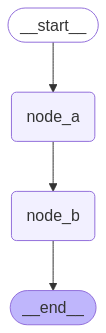

{'foo': 'b', 'bar': ['a', 'b']}

In [43]:
# checkpoints, threads and  checkpointers
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

display(draw_graph(graph))

# using a thread id allows us to store the checkpoints
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

In [44]:
# get the latest state
config = {"configurable": {"thread_id": "1"}}
graph.get_state(config)

StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da98-6b42-8002-0d3cb4de97fa'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-10T03:11:00.144090+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da83-6636-8001-92abe6928ef2'}}, tasks=())

In [47]:
# get state history
config = {"configurable": {"thread_id": "1"}}
list(graph.get_state_history(config))

[StateSnapshot(values={'foo': 'b', 'bar': ['a', 'b']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da98-6b42-8002-0d3cb4de97fa'}}, metadata={'source': 'loop', 'writes': {'node_b': {'foo': 'b', 'bar': ['b']}}, 'step': 2, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-10T03:11:00.144090+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da83-6636-8001-92abe6928ef2'}}, tasks=()),
 StateSnapshot(values={'foo': 'a', 'bar': ['a']}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da83-6636-8001-92abe6928ef2'}}, metadata={'source': 'loop', 'writes': {'node_a': {'foo': 'a', 'bar': ['a']}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-10T03:11:00.135890+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da60-6096-8000-7672a4c64038'}}, tasks=(Preg

In [48]:
# get the state at a specific checkpoint
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f015b96-da60-6096-8000-7672a4c64038"}}
graph.get_state(config)


StateSnapshot(values={'foo': '', 'bar': []}, next=('node_a',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f015b96-da60-6096-8000-7672a4c64038'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-10T03:11:00.121410+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f015b96-da4d-67b9-bfff-feed28041f03'}}, tasks=(PregelTask(id='e40e27b8-beef-5d2a-6829-321f104687cd', name='node_a', path=('__pregel_pull', 'node_a'), error=None, interrupts=(), state=None, result={'foo': 'a', 'bar': ['a']}),))

Replay

In [50]:
# when we `replay`, it does not re-execute the graph until that point 
# it executes all the steps from that particular checkpoint though 
config = {"configurable": {"thread_id": "1", "checkpoint_id": "1f015b96-da4d-67b9-bfff-feed28041f03"}}
graph.invoke(None, config=config)

{'foo': 'b', 'bar': ['a', 'b']}

It's also possible to create "long term" memory where the state is persisted across the threads using a memory saver.

LangGraph currently supports in-memory, sqlite and postgres (for prod) memory savers